### Reinforcement learning: A simple example

In this notebook we will look at a simple example of reinforcement learning.  
Pretend that you have walked into a casino, and that there are four possible slot machines that you can play.  You know that some machines are better than others, but you don't know which is best for this particular set of four.  How do you choose which one to play?  

We will build a simple reinforcement learning model that will learn from experience which of the machines is best.

First, we need to set up our simulation.

In [13]:
import numpy,pandas
import matplotlib.pyplot as plt
from scipy import misc

numpy.random.seed(2) # make it reproducible


Let's say that the four machines vary in their probability of paying out $1 on any particular trial:

* Machine 1: 0.85
* Machine 2: 0.4
* Machine 3: 0.35
* Machine 4: 0.1

That, Machine 1 is much better than the others, whereas Machines 2 and 3 are in the middle and Machine 4 is particularly bad.

In [14]:
payout_probability = numpy.array([0.85,0.4,0.35,0.1])

In a reinforcement learning model, we need to estimate the value of each action in order to determine which actions to choose.  Since we don't know up front, let's start with the value of each action set to the same amount (zero).

In [15]:
Q = numpy.zeros(4)

Now we need to set up the learning process.  On each trial, we will choose one of the actions, using the value that we have estimated. You might imagine that we would always choose the action with the highest estimated value, but this is a bad idea, as it will end up with us always choosing the first machine that was rewarded. This is the problem of *action selection*.  We will use a simple approach to solve the problem: We will use the estimated values, but then introduce some randomness into the process so that we will sometimes we will choose a less-valued option.  We do this using a function called the *softmax*, which chooses actions with a probability based on the relative value of each option.

The function in the next cell does the main work of the reinforcement learning model.  It takes in the current values for the options, chooses an option using the softmax function, and then updates the values based on the outcome.  A value called the *learning rate* determines how much we change our value estimates based on experience.  

In [16]:
def softmax_selection(value,temperature):
    # take in a set of values and temperature value
    # - temperature determines the amount of randomness in the action selection process
    # return an action selection
    
    # compute the softmax values for each action
    sm = numpy.exp(value/temperature)/numpy.sum(numpy.exp(value/temperature))
    
    # choose a random number between zero and 1
    p = numpy.random.rand()
    
    # choose an action based on the softmax probabilities
    action = numpy.min(numpy.where(p<numpy.cumsum(sm)))
    
    return(action)
    


def trial_function(value,temperature = .2):
    # choose an action
    sm = softmax_selection(value,temperature)
    
    # determine outcome based on probability of payout for selected machine
    win = (numpy.random.rand() < payout_probability[sm]).astype('int')
    
    return(sm,win)

In [17]:
ntrials = 1000
learning_rate=0.005

Q = numpy.zeros((ntrials+1,len(payout_probability)))
sm = numpy.zeros(ntrials,dtype=int)
win = numpy.zeros(ntrials,dtype=int)

for i in range(ntrials):
    sm[i],win[i] = trial_function(Q[i,:])
    Q[i+1,:]=Q[i,:]
    Q[i+1,sm[i]] = Q[i,sm[i]] + learning_rate*(win[i] - Q[i,sm[i]])
    

Now let's summarize the data.  We will break it into chunks of 20 trials, and look at how often the model chose each of the machines as learning progressed.

In [18]:
block_length=50
nblocks = int(ntrials/block_length)
blocknums = numpy.kron(numpy.arange(ntrials/block_length),numpy.ones(block_length))
data = pandas.DataFrame({'pwin':numpy.zeros(nblocks)})
for i in range(len(payout_probability)):
    data['choices%d'%i]=numpy.zeros(nblocks)
                         
for i in range(nblocks):
    data['pwin'][i]=numpy.mean(win[blocknums==i])
    for j in range(len(payout_probability)):
        data['choices%d'%j][i]=numpy.sum(sm[blocknums==i]==j)/block_length
        

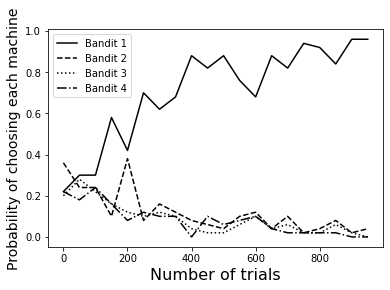

In [30]:
#plt.plot(numpy.arange(0,ntrials,block_length),data.iloc[:,1:])
plt.plot(numpy.arange(0,ntrials,block_length),data.iloc[:,1], 'k-')
plt.plot(numpy.arange(0,ntrials,block_length),data.iloc[:,2], 'k--')
plt.plot(numpy.arange(0,ntrials,block_length),data.iloc[:,3], 'k:')
plt.plot(numpy.arange(0,ntrials,block_length),data.iloc[:,4], 'k-.')

plt.legend(['Bandit %d'% (i + 1) for i in range(len(payout_probability))])
plt.xlabel('Number of trials',fontsize=16)
plt.ylabel('Probability of choosing each machine',fontsize=14)
plt.savefig('RLperformance.png')

Text(0, 0.5, 'Average amount won per trial')

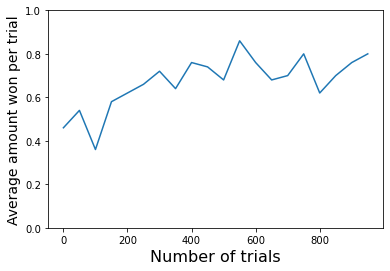

In [8]:
plt.plot(numpy.arange(0,ntrials,block_length),data.iloc[:,0])
plt.xlabel('Number of trials',fontsize=16)
plt.ylim([0,1])
plt.ylabel('Average amount won per trial',fontsize=14)

Now let's look at what happens when the contingencies change.  

In [9]:
ntrials = 1000
learning_rate=0.005

Q_reversal = numpy.zeros((ntrials*2+1,len(payout_probability)))
sm_reversal = numpy.zeros(ntrials*2,dtype=int)
win_reversal = numpy.zeros(ntrials*2,dtype=int)

# start with the initial payout probabilities
payout_probability = numpy.array([0.85,0.4,0.35,0.1])

for i in range(ntrials):
    sm_reversal[i],win_reversal[i] = trial_function(Q_reversal[i,:])
    Q_reversal[i+1,:]=Q_reversal[i,:]
    Q_reversal[i+1,sm_reversal[i]] = Q_reversal[i,sm_reversal[i]] + learning_rate*(win_reversal[i] - 
                                                                 Q_reversal[i,sm_reversal[i]])

# now switch the probabilities of Machines 1 and 4
payout_probability = numpy.array([0.1,0.4,0.35,0.85])


for i in range(ntrials,ntrials*2):
    sm_reversal[i],win_reversal[i] = trial_function(Q_reversal[i,:])
    Q_reversal[i+1,:]=Q_reversal[i,:]
    Q_reversal[i+1,sm_reversal[i]] = Q_reversal[i,sm_reversal[i]] + learning_rate*(win_reversal[i] - 
                                                                          Q_reversal[i,sm_reversal[i]])


In [10]:
block_length=50
nblocks = int(ntrials*2/block_length)
blocknums = numpy.kron(numpy.arange(ntrials*2/block_length),numpy.ones(block_length))
data = pandas.DataFrame({'pwin':numpy.zeros(nblocks)})
for i in range(len(payout_probability)):
    data['choices%d'%i]=numpy.zeros(nblocks)
                         
for i in range(nblocks*2):
    data['pwin'][i]=numpy.mean(win_reversal[blocknums==i])
    for j in range(len(payout_probability)):
        data['choices%d'%j][i]=numpy.sum(sm_reversal[blocknums==i]==j)/block_length
        

/Users/poldrack/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/poldrack/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Probability of choosing each machine')

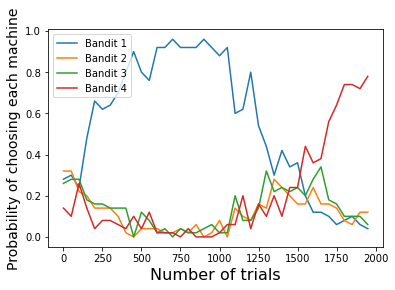

In [11]:
plt.plot(numpy.arange(0,ntrials*2,block_length),data.iloc[:,1:])
plt.legend(['Bandit %d'% (i + 1) for i in range(len(payout_probability))])
plt.xlabel('Number of trials',fontsize=16)
plt.ylabel('Probability of choosing each machine',fontsize=14)
